In [19]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir('../input'))

# Any results you write to the current directory are saved as output.

['sample_submission.csv', 'plates']


In [20]:
data_root = '../input/plates/plates/'
print(os.listdir(data_root))

['test', 'train']


In [21]:
import shutil 
from tqdm import tqdm

train_dir = 'train'
val_dir = 'val'

class_names = ['cleaned', 'dirty']

# Создаем папки для тренировки и валидации
for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)
        
# Каждый шестой сэмпл в валидацию
for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, filename in enumerate(tqdm(os.listdir(source_dir))):
        if i % 6 != 0:
            dest_dir = os.path.join(train_dir, class_name)
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, filename), os.path.join(dest_dir, filename))


100%|██████████| 20/20 [00:00<00:00, 340.29it/s]


In [59]:
import torch
import torchvision
import matplotlib.pyplot as plt
import time
import copy
from torchvision import transforms, models
import PIL

shift_const = [0.485, 0.456, 0.406]
scale_const = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    transforms.Pad(50, padding_mode='edge'),
    transforms.RandomRotation((0, 360), expand=True),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(shift_const, scale_const)
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(shift_const, scale_const)
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

batch_size = 8

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)


In [36]:
print(len(train_loader), len(train_dataset))
print(len(val_loader), len(val_dataset))

4 32
1 8


1


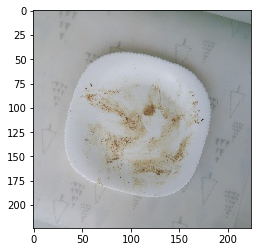

In [57]:
X_batch, y_batch = next(iter(train_loader))
plt.imshow(X_batch[0].permute(1, 2, 0).numpy()*scale_const + shift_const);
print(y_batch[0].item())

In [42]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy() * scale_const + shift_const
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

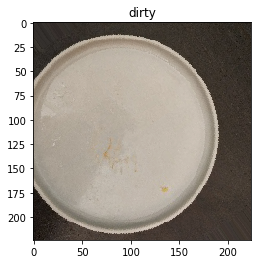

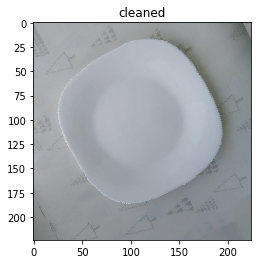

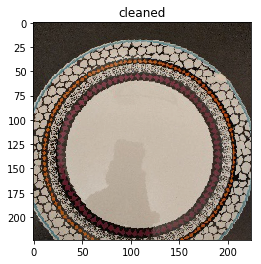

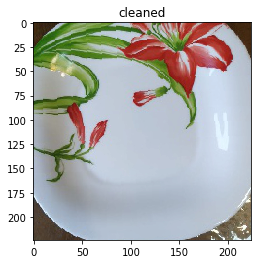

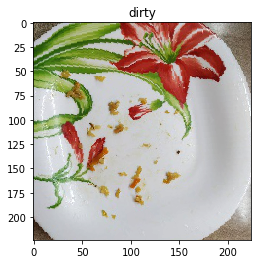

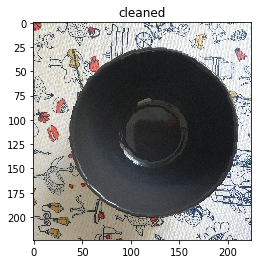

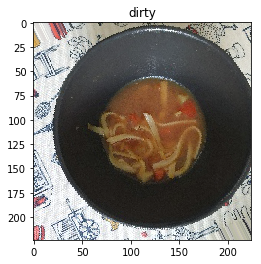

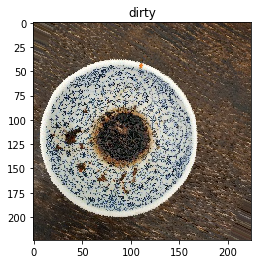

In [60]:
X_batch, y_batch = next(iter(train_loader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

In [72]:
model = models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False
    
model.fc = torch.nn.Linear(model.fc.in_features, 2)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), amsgrad=True, lr=1.0e-3)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.6)

In [62]:
def train_model(model, loss, optimizer, scheduler, n_epochs):
    for epoch in range(n_epochs):
        print('Epoch {}:'.format(epoch))
        
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_loader
#                 scheduler.step()
                model.train()
            else:
                dataloader = val_loader
                model.eval()
                
            batch_loss = 0.
            batch_acc = 0.
            
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_val = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)
                    
                    if phase == 'train':
                        loss_val.backward()
                        optimizer.step()
                        scheduler.step()
                        
                batch_loss += loss_val.item()
                batch_acc += (preds_class == labels.data).float().mean()
                
            epoch_loss = batch_loss / len(dataloader)
            epoch_acc = batch_acc / len(dataloader)
        
            print('{} Loss: {:.3f} Acc: {:.3f}'.format(phase, epoch_loss, epoch_acc))
    return model            

In [73]:
train_model(model, loss, optimizer, scheduler, n_epochs=100)

Epoch 0:
train Loss: 0.653 Acc: 0.562
val Loss: 0.702 Acc: 0.625
Epoch 1:
train Loss: 0.682 Acc: 0.594
val Loss: 0.645 Acc: 0.500
Epoch 2:
train Loss: 0.582 Acc: 0.719
val Loss: 0.612 Acc: 0.750
Epoch 3:
train Loss: 0.477 Acc: 0.781
val Loss: 0.604 Acc: 0.750
Epoch 4:
train Loss: 0.528 Acc: 0.688
val Loss: 0.599 Acc: 0.750
Epoch 5:
train Loss: 0.469 Acc: 0.844
val Loss: 0.589 Acc: 0.750
Epoch 6:
train Loss: 0.433 Acc: 0.875
val Loss: 0.588 Acc: 0.750
Epoch 7:
train Loss: 0.451 Acc: 0.812
val Loss: 0.587 Acc: 0.750
Epoch 8:
train Loss: 0.499 Acc: 0.812
val Loss: 0.598 Acc: 0.500
Epoch 9:
train Loss: 0.493 Acc: 0.781
val Loss: 0.591 Acc: 0.625
Epoch 10:
train Loss: 0.414 Acc: 0.875
val Loss: 0.596 Acc: 0.625
Epoch 11:
train Loss: 0.432 Acc: 0.844
val Loss: 0.585 Acc: 0.625
Epoch 12:
train Loss: 0.541 Acc: 0.719
val Loss: 0.593 Acc: 0.625
Epoch 13:
train Loss: 0.380 Acc: 0.906
val Loss: 0.590 Acc: 0.625
Epoch 14:
train Loss: 0.415 Acc: 0.906
val Loss: 0.588 Acc: 0.625
Epoch 15:
train Loss

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [64]:
test_dir = 'test'
shutil.copytree(os.path.join(data_root, 'test'),
               os.path.join(test_dir, 'unknown'))

'test/unknown'

In [65]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path, ))
        return tuple_with_path

In [66]:
test_dataset = ImageFolderWithPaths(test_dir, val_transforms)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=batch_size)

In [74]:
model.eval()

test_predictions = []
test_img_paths = []
for inputs, _, paths in test_loader:
    inputs = inputs.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(torch.nn.functional.softmax(preds, dim=1)[:, 1].data.cpu().numpy())
    test_img_paths.extend(paths)

test_predictions = np.concatenate(test_predictions)

In [68]:
test_predictions

array([0.71335036, 0.713428  , 0.49829552, 0.98394126, 0.3928533 ,
       0.95806324, 0.9696134 , 0.53755015, 0.6129422 , 0.2470811 ,
       0.8337481 , 0.93605095, 0.1754998 , 0.45326173, 0.46105537,
       0.2833533 , 0.9357212 , 0.13557836, 0.8166726 , 0.79302764,
       0.92007023, 0.69880354, 0.98746884, 0.8661935 , 0.17204425,
       0.40790907, 0.23161492, 0.5093588 , 0.2807925 , 0.89665264,
       0.17004162, 0.8244907 , 0.40160406, 0.7007069 , 0.8139637 ,
       0.8074383 , 0.9445333 , 0.20495348, 0.7084747 , 0.94907796,
       0.97930497, 0.31318074, 0.93235594, 0.98102826, 0.7464913 ,
       0.86695546, 0.9865534 , 0.4711635 , 0.97846395, 0.5113889 ,
       0.40603605, 0.65348566, 0.7420063 , 0.2348882 , 0.07306662,
       0.07226848, 0.8805671 , 0.99529076, 0.9755593 , 0.26863217,
       0.05441368, 0.88224566, 0.34332228, 0.6653418 , 0.7369096 ,
       0.980168  , 0.09380006, 0.19120593, 0.3873549 , 0.6764746 ,
       0.5573188 , 0.1250371 , 0.7786452 , 0.13185777, 0.80857

In [69]:
test_img_paths

['test/unknown/0000.jpg',
 'test/unknown/0001.jpg',
 'test/unknown/0002.jpg',
 'test/unknown/0003.jpg',
 'test/unknown/0004.jpg',
 'test/unknown/0005.jpg',
 'test/unknown/0006.jpg',
 'test/unknown/0007.jpg',
 'test/unknown/0008.jpg',
 'test/unknown/0009.jpg',
 'test/unknown/0010.jpg',
 'test/unknown/0011.jpg',
 'test/unknown/0012.jpg',
 'test/unknown/0013.jpg',
 'test/unknown/0014.jpg',
 'test/unknown/0015.jpg',
 'test/unknown/0016.jpg',
 'test/unknown/0017.jpg',
 'test/unknown/0018.jpg',
 'test/unknown/0019.jpg',
 'test/unknown/0020.jpg',
 'test/unknown/0021.jpg',
 'test/unknown/0022.jpg',
 'test/unknown/0023.jpg',
 'test/unknown/0024.jpg',
 'test/unknown/0025.jpg',
 'test/unknown/0026.jpg',
 'test/unknown/0027.jpg',
 'test/unknown/0028.jpg',
 'test/unknown/0029.jpg',
 'test/unknown/0030.jpg',
 'test/unknown/0031.jpg',
 'test/unknown/0032.jpg',
 'test/unknown/0033.jpg',
 'test/unknown/0034.jpg',
 'test/unknown/0035.jpg',
 'test/unknown/0036.jpg',
 'test/unknown/0037.jpg',
 'test/unkno

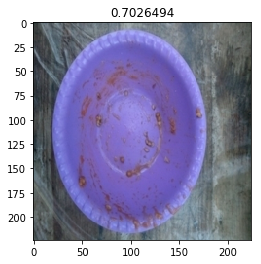

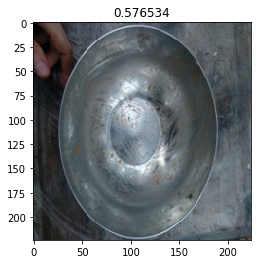

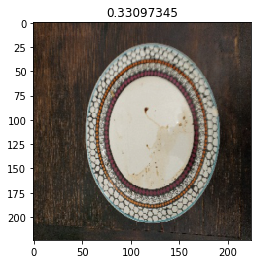

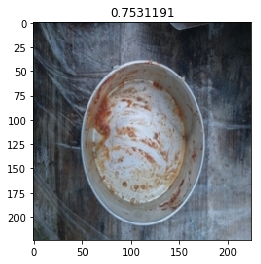

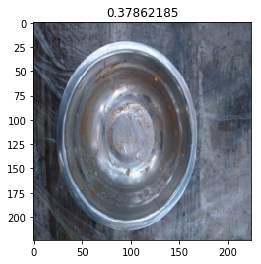

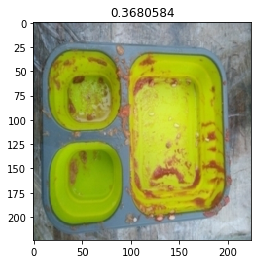

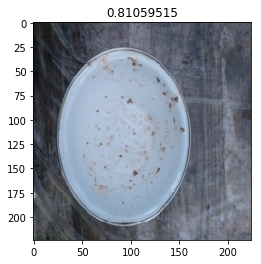

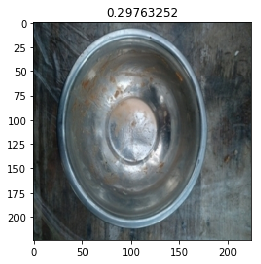

In [75]:
inputs, labels, paths = next(iter(test_loader))

for img, pred in zip(inputs, test_predictions):
    show_input(img, title=pred)

In [71]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths,
                                        'label': test_predictions})

In [ ]:
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty'
                                                   if pred > 0.5 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)

In [ ]:
submission_df.head(6)

In [ ]:
submission_df.to_csv('submission.csv')

In [ ]:
!rm -rf train val test